In [1]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import glob
import numpy as np
import pandas as pd
import functools
import os
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from itertools import product

%matplotlib inline
ia.seed(1)

In [5]:
def bb_midpoint_to_corner(bb):
    label = bb[0]
    x1 = bb[1] - bb[3]/2
    x2 = bb[1] + bb[3]/2
    y1 = bb[2] - bb[4]/2
    y2 = bb[2] + bb[4]/2
    corner_list = [label, x1, x2, y1, y2]
    return np.array(corner_list)

def bb_corner_to_midpoint(bb):
    label = bb[0]
    x = bb[1] + (bb[2] - bb[1])/2
    y = bb[3] + (bb[4] - bb[3])/2
    w = bb[2] - bb[1]
    h = bb[4] - bb[3]
    midpoint_list = [label, x, y, w, h]
    return np.array(midpoint_list)

def bbs_to_bb(bbs_list, width, height):
    try:
        corner_list = []
        for bbs in bbs_list:
            label = bbs.label
            x1 = bbs.x1/width
            x2 = bbs.x2/width
            y1 = bbs.y1/height
            y2 = bbs.y2/height
            corner_list.append([label, x1, x2, y1, y2])

        midpoint_list = np.apply_along_axis(bb_corner_to_midpoint, axis=1, arr=corner_list)
        return np.array(midpoint_list)
    except Exception as e:
        #print(e)
        return np.array([])

def save_bb_txt(bbs_df, name):
    bbs_df.to_csv(name, index = False, header = False, sep = " ", float_format='%.6f')

def open_yolo(image_name, label_path):
    try: 
        image = imageio.imread(image_name)
        shape = image.shape
        width = shape[1]
        height = shape[0]
        label = label_path + image_name.split("/")[-1].split(".")[0] + ".txt"
        boxes = np.genfromtxt(label, delimiter=' ')
        bb = boxes
        # reshaping the np array is necessary in case a file with a single box is read
        boxes = boxes.reshape(boxes.size//5, 5)
        #print(boxes.shape)
        boxes = np.apply_along_axis(bb_midpoint_to_corner, axis=1, arr=boxes)
        bbs = BoundingBoxesOnImage([BoundingBox(x1=list[1]*width, x2=list[2]*width, y1=list[3]*height, y2=list[4]*height, label = int(list[0])) for list in boxes], shape=image.shape)
        return image, bbs, bb
    except Exception as e:
        #print(e)
        return None, None

def calculate_position(index, factor):
    # since the crops are center aligned, the edges (0.0 and 1.0) can't use the same expression
    return 1 if index == 0 else 0 if index == (factor - 1) else (1 - index/factor) - 1/(factor*2)

In [3]:
image_path = "../yolo-station/images_bgr/"
label_path = "../yolo-station/labels_sub/"

image_list = os.path.join(os.path.join(image_path, "*.*"))
label_list = []

image_list = glob.glob(image_list)
for name in image_list:
    label_list.append(label_path + name.split("/")[-1].split(".")[0] + ".txt")


In [18]:
import networkx as nx

bb_graph = nx.Graph()
print(bb_graph)


In [143]:
def intersection_over_union(box1, box2):
    """
    Video explanation of this function:
    https://youtu.be/XXYG5ZWtjj0
    This function calculates intersection over union (iou) given two
    bounding boxes.
    Parameters:
        box1 (dict): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        box2 (dict): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        float: Intersection over union for all examples
    """

    box1_x1 = box1["x"] - box1["w"]/2
    box1_y1 = box1["y"] - box1["h"]/2
    box1_x2 = box1["x"] + box1["w"]/2
    box1_y2 = box1["y"] + box1["h"]/2
    box2_x1 = box2["x"] - box2["w"]/2
    box2_y1 = box2["y"] - box2["h"]/2
    box2_x2 = box2["x"] + box2["w"]/2
    box2_y2 = box2["y"] + box2["h"]/2

    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)

    intersection = (x2 - x1) * (y2 - y1)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    union = (box1_area + box2_area - intersection)

    return box1_area, box2_area, intersection, union, intersection / union

def intersection(box1, box2):
    """
    Video explanation of this function:
    https://youtu.be/XXYG5ZWtjj0
    This function calculates intersection over union (iou) given two
    bounding boxes.
    Parameters:
        box1 (dict): Predictions of Bounding Boxes
        box2 (dict): Correct labels of Bounding Boxes
    Returns:
        float: the area of the first box
        float: the area of the second box
        float: Intersection of the two boxes
    """
    box1_x1 = box1["x"] - box1["w"]/2
    box1_y1 = box1["y"] - box1["h"]/2
    box1_x2 = box1["x"] + box1["w"]/2
    box1_y2 = box1["y"] + box1["h"]/2
    box2_x1 = box2["x"] - box2["w"]/2
    box2_y1 = box2["y"] - box2["h"]/2
    box2_x2 = box2["x"] + box2["w"]/2
    box2_y2 = box2["y"] + box2["h"]/2

    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)

    intersection = (x2 - x1) * (y2 - y1)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return box1_area, box2_area, intersection

In [237]:
for im in image_list[0:1]:
    count = 0
    image_name = im
    #print(image_name)
    image, bbs, bb = open_yolo(image_name, label_path)
    shape = image.shape
    width = shape[1]
    height = shape[0]
    h_factor = height//480
    w_factor = width//640
    bb_graph = nx.Graph()
    count = 0
    for box in bb:
        box[1] = int(box[1] * width)
        box[2] = int(box[2] * height)
        box[3] = int(box[3] * width)
        box[4] = int(box[4] * height)
        bb_graph.add_node(count, x = box[1], y = box[2], w = box[3], h = box[4])
        count +=1
    print(bb_graph.nodes.data())

    

[(0, {'x': 692.0, 'y': 657.0, 'w': 390.0, 'h': 487.0}), (1, {'x': 343.0, 'y': 893.0, 'w': 116.0, 'h': 133.0}), (2, {'x': 176.0, 'y': 106.0, 'w': 98.0, 'h': 199.0}), (3, {'x': 552.0, 'y': 757.0, 'w': 101.0, 'h': 106.0}), (4, {'x': 367.0, 'y': 575.0, 'w': 40.0, 'h': 70.0}), (5, {'x': 221.0, 'y': 540.0, 'w': 40.0, 'h': 70.0}), (6, {'x': 482.0, 'y': 601.0, 'w': 37.0, 'h': 67.0}), (7, {'x': 516.0, 'y': 763.0, 'w': 128.0, 'h': 102.0})]


In [238]:
    for j, i in product(bb_graph.nodes, bb_graph.nodes):
        if(i != j):
            x = bb_graph.nodes[i]["x"]
            y = bb_graph.nodes[i]["y"]
            if(x + 640//2 > width):
                x = x - (width - 640//2)
            elif(x - 640//2 < 0):
                x = x + (640//2 - x)
            if(y + 480//2 > height):
                y = y - (height - 480//2)
            elif(y - 480//2 < 0):
                y = y + (480//2 - y)
            area1, area2, inter = intersection({
                                        "x": x, 
                                        "y": y,
                                        "w": 640,
                                        "h": 480
                                        },
                                        bb_graph.nodes[j])
            # we only care if the candidate box j is at least 75% inside the crop window
            if(area2*0.75 <= inter <= area2):
                bb_graph.add_edge(i,j)
                print(inter, area2)
                bb_graph[i][j]['weight'] = inter/area2
                print(inter/area2)
                #print(bb_graph.nodes[i])
                #print(bb_graph.nodes[j])
                #print(area2 - inter)
                #print("Area1: {}, Area2: {}, Inter: {}".format(area1, area2, inter))             

19502.0 19502.0
1.0
10706.0 10706.0
1.0
10706.0 10706.0
1.0
10706.0 10706.0
1.0
2800.0 2800.0
1.0
2800.0 2800.0
1.0
2800.0 2800.0
1.0
2800.0 2800.0
1.0
2479.0 2479.0
1.0
2479.0 2479.0
1.0
2479.0 2479.0
1.0
13056.0 13056.0
1.0
13056.0 13056.0
1.0
13056.0 13056.0
1.0


In [201]:
print(bb_graph.number_of_edges())
print(bb_graph.edges())
for node in bb_graph.nodes:
    print("Neighbors of {}: {}".format(node, [n for n in bb_graph.neighbors(node)]))

11
[('0', '3'), ('0', '6'), ('0', '7'), ('1', '2'), ('3', '4'), ('3', '6'), ('4', '5'), ('4', '6'), ('4', '7'), ('5', '6'), ('6', '7')]
Neighbors of 0: ['3', '6', '7']
Neighbors of 1: ['2']
Neighbors of 2: ['1']
Neighbors of 3: ['0', '4', '6']
Neighbors of 4: ['3', '5', '6', '7']
Neighbors of 5: ['4', '6']
Neighbors of 6: ['3', '4', '5', '0', '7']
Neighbors of 7: ['0', '4', '6']


In [ ]:
print(bb_graph.number_of_edges())
print(bb_graph.edges())
for node in bb_graph.nodes:
    print("Neighbors of {}: {}".format(node, [n for n in bb_graph.neighbors(node)]))

{0: Text(44.736, 18.0, '0'),
 1: Text(192.0, 163.64, '1'),
 2: Text(263.21, 153.0, '2'),
 3: Text(122.2, 20.468, '3'),
 4: Text(127.02, 97.376, '4'),
 5: Text(107.19, 159.37, '5'),
 6: Text(80.838, 79.519, '6'),
 7: Text(27.0, 91.061, '7')}

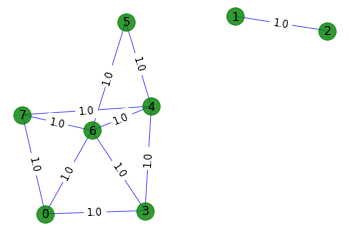

In [239]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

pos = graphviz_layout(bb_graph)
plt.axis('off')
nx.draw_networkx_nodes(bb_graph,pos,node_color='g',alpha = 0.8)  # draws nodes
nx.draw_networkx_edges(bb_graph,pos,edge_color='b',alpha = 0.6)  # draws edges
nx.draw_networkx_edge_labels(bb_graph,pos,edge_labels = nx.get_edge_attributes(bb_graph,'weight')) # edge lables
nx.draw_networkx_labels(bb_graph,pos) # node lables

In [282]:
# greedy answer: we will separate the connected subgraphs and get the node with most neighbors of each
bb_subgraphs = (bb_graph.subgraph(c) for c in nx.connected_components(bb_graph))
count = 0
crops = []
for sub in bb_subgraphs:
    print("Graph {}:".format(count))
    neighbors = {}
    for node in sub.nodes:
        print("Neighbors of {}: {}".format(node, [n for n in sub.neighbors(node)]))
        neighbors[node] = [n for n in sub.neighbors(node)]
    most_neighbors = max(len(item) for item in neighbors.values())
    popular_node = [index for index in neighbors if len(neighbors[index]) == most_neighbors][0]
    crops.append(sub.nodes[popular_node])
    print("Node {} is the most popular, with {} neighbors.".format(popular_node, most_neighbors))
    print("Node coordinates: " + str(sub.nodes[popular_node]))
    count+=1

print(crops)

Graph 0:
Neighbors of 0: [3, 6, 7]
Neighbors of 3: [0, 4, 6]
Neighbors of 4: [3, 5, 6, 7]
Neighbors of 5: [4, 6]
Neighbors of 6: [3, 4, 5, 0, 7]
Neighbors of 7: [0, 4, 6]
Node 6 is the most popular, with 5 neighbors.
Node coordinates: {'x': 482.0, 'y': 601.0, 'w': 37.0, 'h': 67.0}
Graph 1:
Neighbors of 1: [2]
Neighbors of 2: [1]
Node 1 is the most popular, with 1 neighbors.
Node coordinates: {'x': 343.0, 'y': 893.0, 'w': 116.0, 'h': 133.0}
[{'x': 482.0, 'y': 601.0, 'w': 37.0, 'h': 67.0}, {'x': 343.0, 'y': 893.0, 'w': 116.0, 'h': 133.0}]


In [262]:
for sub in connected_bb_subgraphs:
    neighbors = {}
    for node in sub.nodes:
        neighbors[node] = [n for n in bb_graph.neighbors(node)]
        most_neighbors = max(len(item) for item in neighbors.values())
        print(most_neighbors)

AttributeError: 'set' object has no attribute 'nodes'

In [258]:
neighbors = {}
for node in bb_graph.nodes:
    neighbors[node] = [n for n in bb_graph.neighbors(node)]

most_neighbors = max(len(item) for item in neighbors.values())
print(most_neighbors)
popular_node = [index for index in neighbors if len(neighbors[index]) == most_neighbors][0]
accounted_nodes = []
accounted_nodes.append(popular_node)
for n in neighbors[popular_node]:
    accounted_nodes.append(n)
print("Node {} with neighbors {}.".format(popular_node, neighbors[popular_node]))
print(accounted_nodes)


5
Node 6 with neighbors [3, 4, 5, 0, 7].
[6, 3, 4, 5, 0, 7]


In [224]:
neighbors = {}
for node in bb_graph.nodes:
    neighbors[node] = [n for n in bb_graph.neighbors(node)]

# find the node with the most neighbors in the list
most_neighbors = max(len(item) for item in neighbors.values())
popular_node = [[key, value] for [key, value] in neighbors if len([key, value]) == most_neighbors]
print(popular_node[0])
# get the index of this node
#big_index = neighbors.index(big_neighbor)
# pop node with the most neighbors from the list of nodes
#bb_graph.remove_node(big_index)
#print("Box {} has the most neighbours: {}".format(big_neighbor))
print(neighbors)
# remove all nodes that had this removed node as a neighbor


NameError: name 'key' is not defined

In [205]:
for node in bb_graph.nodes:
    print("Neighbors of {}: {}".format(node, [n for n in bb_graph.neighbors(node)]))

Neighbors of 0: ['3', '6', '7']
Neighbors of 1: ['2']
Neighbors of 2: ['1']
Neighbors of 3: ['0', '4', '6']
Neighbors of 4: ['3', '5', '6', '7']
Neighbors of 5: ['4', '6']
Neighbors of 6: ['3', '4', '5', '0', '7']
Neighbors of 7: ['0', '4', '6']


{0, 3, 4, 5, 6, 7}


In [ ]:
cropped_boxes = big_neighbor


In [166]:
cliques = [n for n in nx.find_cliques(bb_graph)]
print(cliques)

big_clique = max(len(c) for c in cliques)
big_clique = max(cliques, key=len)
big_clique_crop = 
big_clique = cliques.remove(big_clique)
print(cliques)
print(big_clique)


[[1, 2], [6, 0, 3], [6, 0, 7], [6, 4, 3], [6, 4, 5], [6, 4, 7]]
[[1, 2], [6, 0, 3], [6, 0, 7], [6, 4, 5], [6, 4, 7]]
[6, 4, 3]


In [171]:
[bb_graph.remove_node(node) for node in big_clique]

NetworkXError: The node 6 is not in the graph.

{0: Text(27.0, 28.639, '0'),
 1: Text(117.0, 73.639, '1'),
 2: Text(188.21, 63.0, '2'),
 5: Text(45.0, 99.0, '5'),
 7: Text(98.21, 18.0, '7')}

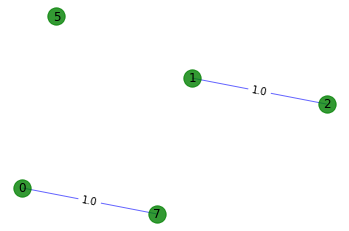

In [172]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

pos = graphviz_layout(bb_graph)
plt.axis('off')
nx.draw_networkx_nodes(bb_graph,pos,node_color='g',alpha = 0.8)  # draws nodes
nx.draw_networkx_edges(bb_graph,pos,edge_color='b',alpha = 0.6)  # draws edges
nx.draw_networkx_edge_labels(bb_graph,pos,edge_labels = nx.get_edge_attributes(bb_graph,'weight')) # edge lables
nx.draw_networkx_labels(bb_graph,pos) # node lables

In [4]:
augmented_count = 0
image_count = 0
print("Number of images: {}".format(len(image_list)))
for im in image_list[0:5]:
    count = 0
    image_name = im
    #print(image_name)
    image, bbs = open_yolo(image_name, label_path)
    # if the image or the label file doesn't exist, skip this iteration
    if((image is None) or (bbs is None)):
        continue
    image_count += 1
    shape = image.shape
    width = shape[1]
    height = shape[0]
    h_factor = height//480
    w_factor = width//640    

    xs = [calculate_position(i, w_factor) for i in range(0, w_factor)]
    ys = [calculate_position(j, h_factor) for j in range(0, h_factor)]
    for y, x in product(xs, ys):
        # position tuple: left-right, low-high ranging from 0.0 to 1.0
        # only boxes with 40% or more inside the crop are kept
        seq = iaa.Sequential([iaa.CropToFixedSize(width=640, height=480, position=(x, y)),
                              ])
        image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
        bbs_aug = bbs_aug.remove_out_of_image().clip_out_of_image()

        #before_image = bbs.draw_on_image(image, size=2)
        #after_image = bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255])
        #ia.ia.show_grid([before_image, after_image], rows=1, cols=2)

        bb = bbs_to_bb(bbs_aug, 640, 480)
        # we only want to save the image if it has boxes in it
        if (len(bb) > 0):
            aug_name = image_name.split("/")[-1].split(".")[0]
            # saving the image
            imageio.imwrite("./crop_images/" + aug_name + "_crop_" + str(count) + ".jpg", image_aug)            
            #print(aug_name + "_aug_" + str(count))
            # saving the YOLO bb file
            df_bb = pd.DataFrame(bb, columns = ["label", "x", "y", "w", "h"])
            df_bb["label"] = df_bb["label"].astype(int)
            save_bb_txt(df_bb, "./crop_labels/" + aug_name + "_crop_" + str(count) + ".txt")
            augmented_count += 1
        count += 1
print("Number of images with boxes: {}".format(image_count))
print("Number of cropped images: {}".format(augmented_count))

Number of images: 633
Number of images with boxes: 5
Number of cropped images: 24
